In [10]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report


In [11]:
# Load weather and location data
weather_df = pd.read_csv("../../data/weather.csv")
location_df = pd.read_csv("../../data/locations.csv")

# Merge on location_id
df = pd.merge(weather_df, location_df, on="location_id")
print("✅ Merged data shape:", df.shape)


✅ Merged data shape: (142371, 28)


In [12]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday

# Convert sunrise and sunset to minutes since midnight
def time_to_minutes(t):
    if pd.isnull(t):
        return np.nan
    return t.hour * 60 + t.minute

df['sunrise'] = pd.to_datetime(df['sunrise'], errors='coerce').dt.time
df['sunset'] = pd.to_datetime(df['sunset'], errors='coerce').dt.time
df['sunrise_mins'] = df['sunrise'].apply(time_to_minutes)
df['sunset_mins'] = df['sunset'].apply(time_to_minutes)

# Target column: RainToday
df['RainToday'] = df['rain_sum (mm)'].apply(lambda x: 1 if x > 0 else 0)


/tmp/ipykernel_541/1896069685.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['sunrise'] = pd.to_datetime(df['sunrise'], errors='coerce').dt.time
/tmp/ipykernel_541/1896069685.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['sunset'] = pd.to_datetime(df['sunset'], errors='coerce').dt.time


In [22]:
# Drop non-numeric and unnecessary columns
drop_cols = [
    'timezone', 'timezone_abbreviation',
     'sunrise', 'sunset', 'RainToday'  # we'll keep RainToday separately
]

X = df.drop(columns=drop_cols)
X = X.select_dtypes(include='number')  # keep only numeric
X['RainToday'] = df['RainToday']

# Save clean data
cleaned_path = "../fc212025 udayanga/clean_data.csv"
X.to_csv(cleaned_path, index=False)
print(f"🧼 Clean data saved to: {cleaned_path}")


🧼 Clean data saved to: ../fc212025 udayanga/clean_data.csv


In [14]:
# Reload clean data for training
clean_df = pd.read_csv(cleaned_path)

# Split features and target
X = clean_df.drop(columns=["RainToday"])
y = clean_df["RainToday"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.2%}")
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Model Accuracy: 100.00%

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6110
           1       1.00      1.00      1.00     22365

    accuracy                           1.00     28475
   macro avg       1.00      1.00      1.00     28475
weighted avg       1.00      1.00      1.00     28475



/tmp/ipykernel_541/1210692022.py:11: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


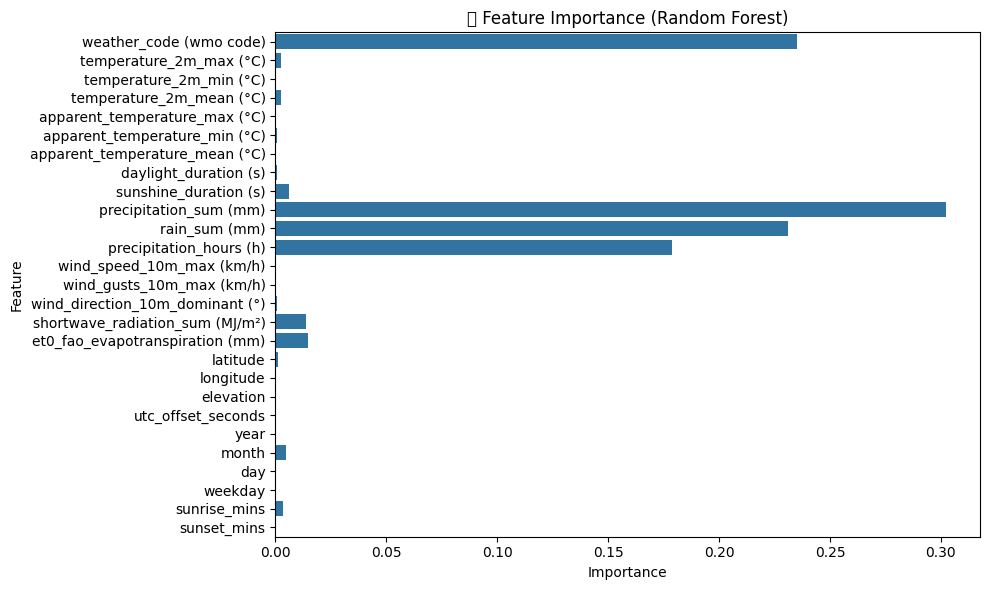

In [15]:
# Feature importance
importances = model.feature_importances_
feature_names = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title("📈 Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [16]:
model_path = "../../models/random_forest.pkl"
os.makedirs(os.path.dirname(model_path), exist_ok=True)

with open(model_path, "wb") as f:
    pickle.dump(model, f)

print(f"💾 Model saved to: {model_path}")


💾 Model saved to: ../../models/random_forest.pkl


In [17]:
# Load model
with open(model_path, "rb") as f:
    loaded_model = pickle.load(f)

# Predict on new data (e.g. first 5 rows of test set)
new_preds = loaded_model.predict(X_test.head(5))
print("🔮 Predictions for new data:", new_preds)


🔮 Predictions for new data: [0 1 1 1 1]


In [18]:
y_pred = model.predict(X_test)
y_pred
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Model Accuracy: {accuracy:.2%}")

✅ Model Accuracy: 100.00%


In [19]:
# Save model to models/random_forest.pkl
model_output_path = "../../models/random_forest.pkl"
os.makedirs(os.path.dirname(model_output_path), exist_ok=True)

with open(model_output_path, "wb") as f:
    pickle.dump(model, f)

print(f"💾 Model saved to {model_output_path}")


💾 Model saved to ../../models/random_forest.pkl


In [20]:
# Predict on a few rows
sample = X_test.iloc[:5]
predictions = model.predict(sample)

print("🔮 Predictions for sample:", predictions)


🔮 Predictions for sample: [0 1 1 1 1]


In [21]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[ 6110,     0],
       [    0, 22365]])